In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("GSOD Data Exploration").getOrCreate()

df = spark.read.parquet("/home/jovyan/Project/gsod_parquet_enriched")
df.printSchema()


root
 |-- STATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- NAME: string (nullable = true)
 |-- TEMP: double (nullable = true)
 |-- DEWP: double (nullable = true)
 |-- SLP: double (nullable = true)
 |-- STP: double (nullable = true)
 |-- VISIB: double (nullable = true)
 |-- WDSP: double (nullable = true)
 |-- MXSPD: double (nullable = true)
 |-- GUST: double (nullable = true)
 |-- MAX: string (nullable = true)
 |-- MIN: string (nullable = true)
 |-- PRCP: string (nullable = true)
 |-- SNDP: double (nullable = true)
 |-- FRSHTT: string (nullable = true)
 |-- CTRY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- ELEV: double (nullable = true)
 |-- year: integer (nullable = true)



In [ ]:
###  Column Descriptions 

| Column     | Description |
|------------|-------------|
| `STATION`  | Unique station identifier (USAF + WBAN) |
| `DATE`     | Observation date (`YYYY-MM-DD`) |
| `LATITUDE` | Station latitude (from GSOD data) |
| `LONGITUDE`| Station longitude (from GSOD data) |
| `ELEVATION`| Station elevation in meters (from GSOD) |
| `NAME`     | Station name (if available) |
| `TEMP`     | Mean daily temperature (°F) |
| `DEWP`     | Mean daily dew point (°F) |
| `SLP`      | Sea-level pressure (mb) |
| `STP`      | Station pressure (mb) |
| `VISIB`    | Mean visibility (miles) |
| `WDSP`     | Mean wind speed (knots) |
| `MXSPD`    | Max sustained wind speed (knots) |
| `GUST`     | Max wind gust (knots) |
| `MAX`      | Max temperature (may include `*` flag) |
| `MIN`      | Min temperature (may include `*` flag) |
| `PRCP`     | Precipitation (inches; may include quality flags `A`, `I`, etc.) |
| `SNDP`     | Snow depth (inches) |
| `FRSHTT`   | Encoded weather flags: Fog, Rain, Snow, Hail, Thunder, Tornado |
| `year`     | Extracted 4-digit year from the `DATE` column |
| `CTRY`     | Country code from station metadata (e.g., `US`, `CA`, `DE`) |
| `STATE`    | U.S. state/region code from metadata (blank for non-U.S. stations) |


In [2]:
print(f"Total records: {df.count():,}")
df.groupBy("year").count().orderBy("year", ascending=False).show(10)

Total records: 151,898,241
+----+-------+
|year|  count|
+----+-------+
|2023|4038747|
|2022|3994717|
|2021|4026550|
|2020|4119205|
|2019|4166563|
|2018|4130871|
|2017|4156593|
|2016|3997629|
|2015|4021868|
|2014|3930772|
+----+-------+
only showing top 10 rows



In [3]:
df.describe(["TEMP", "PRCP", "WDSP", "SLP"]).show()


+-------+-----------------+------------------+-----------------+------------------+
|summary|             TEMP|              PRCP|             WDSP|               SLP|
+-------+-----------------+------------------+-----------------+------------------+
|  count|        151898239|         151898239|        151898239|         151898239|
|   mean|53.41107993358642|30.482502883344413|8.652701925003884|481.59671949151885|
| stddev|23.71387421800863| 152.4100313139774|8.575782153108358|2044.3538843211702|
|    min|           -118.5|               0.0|              0.0|            -126.6|
|    max|            110.0|             999.9|             24.0|            9999.9|
+-------+-----------------+------------------+-----------------+------------------+



In [4]:
# Missing Data
from pyspark.sql.functions import col, count, when

df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
]).show()


+-------+----+--------+---------+---------+------+----+----+---+---+-----+----+-----+----+---+---+----+----+------+------+---------+------+------+------+----+
|STATION|DATE|LATITUDE|LONGITUDE|ELEVATION|  NAME|TEMP|DEWP|SLP|STP|VISIB|WDSP|MXSPD|GUST|MAX|MIN|PRCP|SNDP|FRSHTT|  CTRY|    STATE|   LAT|   LON|  ELEV|year|
+-------+----+--------+---------+---------+------+----+----+---+---+-----+----+-----+----+---+---+----+----+------+------+---------+------+------+------+----+
|      0|   0|  739994|   740285|   761102|576872|   2|   2|  2|  2|    2|   2|    2|   2|  2|  2|   2|   2|     2|607049|121914000|740468|740759|794188|   0|
+-------+----+--------+---------+---------+------+----+----+---+---+-----+----+-----+----+---+---+----+----+------+------+---------+------+------+------+----+



In [6]:
# Average global temp change over the decades

from pyspark.sql.functions import col, floor, avg, lag
from pyspark.sql.window import Window

df = df.withColumn("decade", (floor(col("year") / 10) * 10).cast("int"))

df_decade_avg = df.groupBy("decade").agg(avg("TEMP").alias("avg_temp")).orderBy("decade")

windowSpec = Window.orderBy("decade")
df_diff = df_decade_avg.withColumn("temp_diff", col("avg_temp") - lag("avg_temp").over(windowSpec))

df_diff.show()

+------+------------------+------------------+
|decade|          avg_temp|         temp_diff|
+------+------------------+------------------+
|  1970|49.673491647418764|              NULL|
|  1980| 50.98088132938364| 1.307389681964878|
|  1990| 53.40736180327949|2.4264804738958503|
|  2000|54.495102723502576|1.0877409202230837|
|  2010| 54.75310132651397|0.2579986030113943|
|  2020| 55.60520240770544|0.8521010811914707|
+------+------------------+------------------+



In [8]:
df.groupBy("CTRY").agg(avg("TEMP")).orderBy("avg(TEMP)").show(10)


+----+------------------+
|CTRY|         avg(TEMP)|
+----+------------------+
|  AY|-2.780049513274849|
|  AQ|  16.9210938061364|
|  GL| 22.22283576697378|
|  SV|24.454082415719306|
|  BV| 29.80845701484179|
|  RS| 30.28485664204345|
|  MG|32.700472500665136|
|  CA|35.649001524082756|
|  SX|  35.9744011722933|
|  RU| 36.18762626262627|
+----+------------------+
only showing top 10 rows



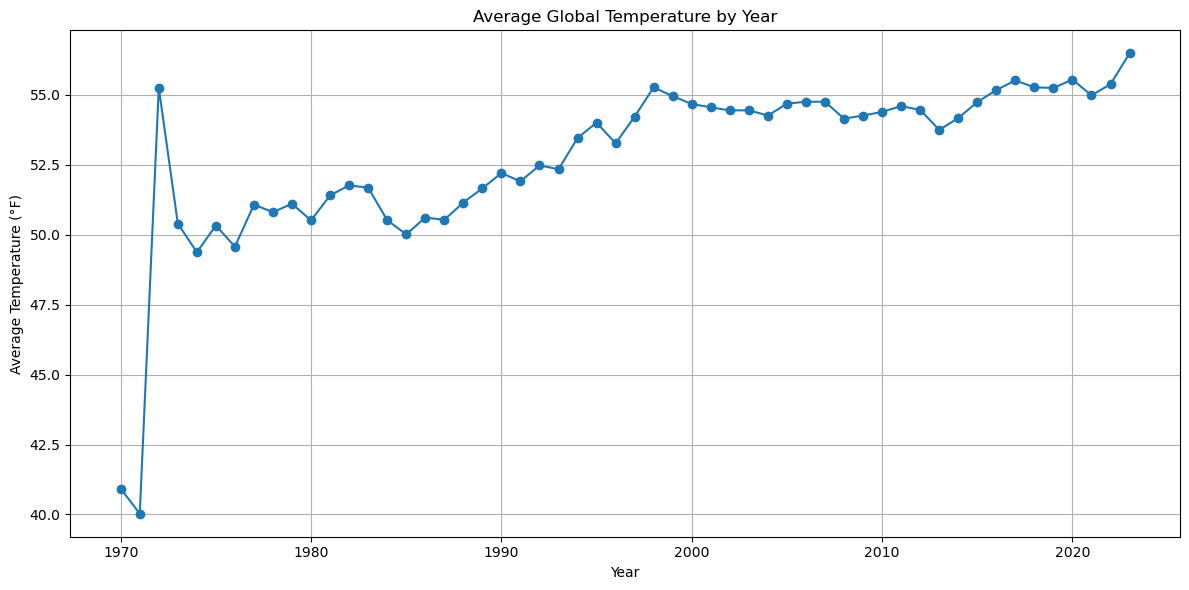

In [7]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt

df_yearly_temp = df.groupBy("year").agg(avg("TEMP").alias("avg_temp")).orderBy("year")
pdf_temp = df_yearly_temp.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pdf_temp["year"], pdf_temp["avg_temp"], marker='o')
plt.title("Average Global Temperature by Year")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°F)")
plt.grid(True)
plt.tight_layout()
plt.show()

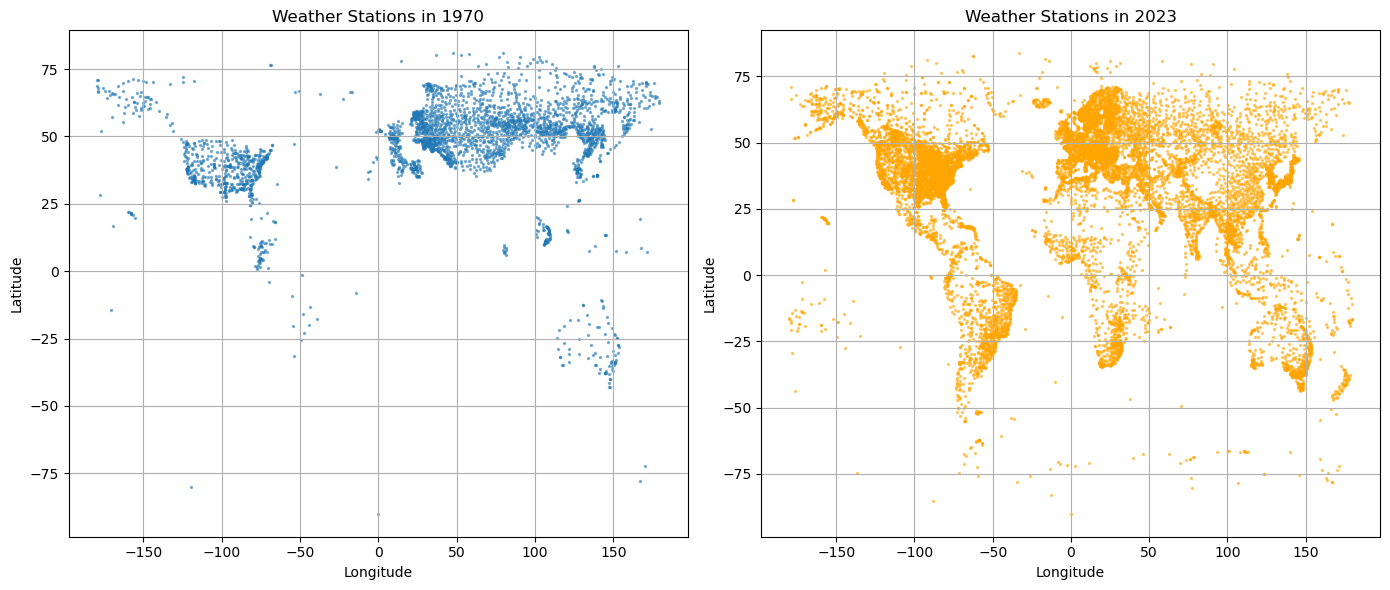

In [9]:
df_stations = df.select("LAT", "LON", "year").dropna().dropDuplicates()

df_1970 = df_stations.filter(col("year") == 1970).toPandas()
df_2023 = df_stations.filter(col("year") == 2023).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# 1970
plt.subplot(1, 2, 1)
plt.scatter(df_1970["LON"], df_1970["LAT"], s=2, alpha=0.5)
plt.title("Weather Stations in 1970")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 2023
plt.subplot(1, 2, 2)
plt.scatter(df_2023["LON"], df_2023["LAT"], s=2, alpha=0.5, color="orange")
plt.title("Weather Stations in 2023")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plt.tight_layout()
plt.show()